# Insect bite identification

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/insect.gif)

There are a variety of insects around us that bite us. These bite effects can vary from itching to venom deposit. Identifying the type of insect is necessary to figure out the best possible way to treat it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
from PIL import Image
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
import keras

# The dataset

In [2]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/insect_bite.zip"
!unzip -qo insect_bite.zip
!rm insect_bite.zip

--2020-12-14 08:37:00--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/insect_bite.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.66.88
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.66.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1976059 (1.9M) [application/zip]
Saving to: ‘insect_bite.zip’

insect_bite.zip     100%[===================>]   1.88M  --.-KB/s    in 0.03s   

2020-12-14 08:37:00 (56.5 MB/s) - ‘insect_bite.zip’ saved [1976059/1976059]



In [3]:
data_dir = 'insect bite'

print("Number of samples in - ")
for f in os.listdir(data_dir + '/'):
    if os.path.isdir(data_dir + '/' + f):
        print('\n'+f.upper())
        for fx in os.listdir(data_dir + '/' + f + '/'):
            print(fx, " : ", len(os.listdir(data_dir + '/' + f +'/' + fx + '/')))

Number of samples in - 

TEST
mosquito  :  2
tick  :  2

TRAIN
mosquito  :  21
tick  :  26

VALIDATION
mosquito  :  5
tick  :  5


In [4]:
batch = 8

# The train, val and test datasets
print("Train dataset")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'/train', batch_size=batch)

print("Validation dataset")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'/validation', batch_size=batch)

print("Test dataset")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'/test', batch_size=batch)

Train dataset
Found 47 files belonging to 2 classes.
Validation dataset
Found 10 files belonging to 2 classes.
Test dataset
Found 4 files belonging to 2 classes.


In [5]:
# Looking into the class names

class_names = train_ds.class_names
print(class_names)

['mosquito', 'tick']


# Visualization

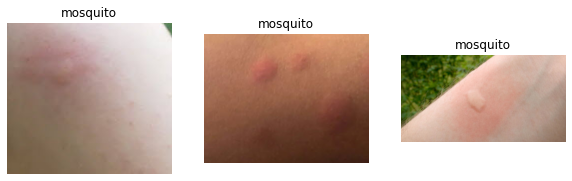

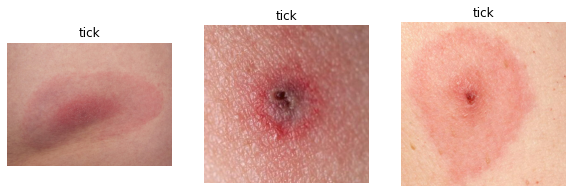

In [6]:
num_samples = 3    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(10, 10))

    filenames = os.listdir(data_dir + '/train/' + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(data_dir + '/train/' + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

# Preprocessing

In [7]:
# Looking into the shape of the batches and individual samples
# Set the input shape

print("Looking into the shape of images and labels in one batch\n")  

for image_batch, labels_batch in train_ds:
    input_shape = image_batch[0].shape
    print("Shape of images input for one batch: ", image_batch.shape)
    print("Shape of images labels for one batch: ", labels_batch.shape)
    break

Looking into the shape of images and labels in one batch

Shape of images input for one batch:  (8, 256, 256, 3)
Shape of images labels for one batch:  (8,)


In [8]:
# Normalizing the pixel values

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
# Augmenting images in the train set to increase dataset size

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),    # Flip along both axes
        layers.experimental.preprocessing.RandomZoom(0.1),    # Randomly zoom images in dataset
        layers.experimental.preprocessing.RandomRotation((-0.1, 0.1))
    ])


print("Train size (number of batches) before augmentation: ", len(train_ds))

# Apply only to train set    
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

print("Size (number of batches) of augmented dataset: ", len(aug_ds))

#Adding to train_ds
train_ds = train_ds.concatenate(aug_ds)

print("Train size (number of batches) after augmentation: ", len(train_ds))

Train size (number of batches) before augmentation:  6
Size (number of batches) of augmented dataset:  6
Train size (number of batches) after augmentation:  12


# The model

In [10]:
base_model = keras.applications.VGG16(weights='imagenet', input_shape=input_shape, include_top=False)    # False, do not include the classification layer of the model

base_model.trainable = False

inputs = keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

cb = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

In [11]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(0.01), metrics=['accuracy'])

history1 = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks=cb)

Epoch 1/32
12/12 [==============================] - 2s 166ms/step - loss: 0.7699 - accuracy: 0.5000 - val_loss: 0.6552 - val_accuracy: 0.7000
Epoch 2/32
12/12 [==============================] - 1s 83ms/step - loss: 0.6781 - accuracy: 0.5106 - val_loss: 0.7002 - val_accuracy: 0.5000
Epoch 3/32
12/12 [==============================] - 1s 91ms/step - loss: 0.6715 - accuracy: 0.5213 - val_loss: 0.6436 - val_accuracy: 0.6000
Epoch 4/32
12/12 [==============================] - 1s 88ms/step - loss: 0.6643 - accuracy: 0.5745 - val_loss: 0.6391 - val_accuracy: 0.6000
Epoch 5/32
12/12 [==============================] - 1s 85ms/step - loss: 0.6409 - accuracy: 0.6383 - val_loss: 0.6415 - val_accuracy: 0.8000
Epoch 6/32
12/12 [==============================] - 1s 87ms/step - loss: 0.6613 - accuracy: 0.5532 - val_loss: 0.7693 - val_accuracy: 0.5000
Epoch 7/32
12/12 [==============================] - 1s 89ms/step - loss: 0.6485 - accuracy: 0.6170 - val_loss: 0.6361 - val_accuracy: 0.5000
Epoch 8/32
1

In [12]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(0.001), metrics=['accuracy'])

history2 = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks=cb)

Epoch 1/32
12/12 [==============================] - 1s 99ms/step - loss: 0.5808 - accuracy: 0.7447 - val_loss: 0.6304 - val_accuracy: 0.8000
Epoch 2/32
12/12 [==============================] - 1s 85ms/step - loss: 0.5941 - accuracy: 0.7340 - val_loss: 0.6331 - val_accuracy: 0.8000
Epoch 3/32
12/12 [==============================] - 1s 87ms/step - loss: 0.5914 - accuracy: 0.7660 - val_loss: 0.6301 - val_accuracy: 0.8000
Epoch 4/32
12/12 [==============================] - 1s 89ms/step - loss: 0.5747 - accuracy: 0.7660 - val_loss: 0.6321 - val_accuracy: 0.8000
Epoch 5/32
12/12 [==============================] - 1s 84ms/step - loss: 0.5921 - accuracy: 0.6809 - val_loss: 0.6322 - val_accuracy: 0.8000
Epoch 6/32
12/12 [==============================] - 1s 86ms/step - loss: 0.5848 - accuracy: 0.7766 - val_loss: 0.6303 - val_accuracy: 0.8000
Epoch 7/32
12/12 [==============================] - 1s 85ms/step - loss: 0.5892 - accuracy: 0.7340 - val_loss: 0.6305 - val_accuracy: 0.8000
Epoch 8/32
12

In [13]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 1ms/step - loss: 0.6825 - accuracy: 0.7500


[0.6824628114700317, 0.75]

# Plotting the metrics

In [14]:
def plot(history1, history2, variable1, variable2):
    # combining metrics from both trainings    
    var1_history = history1[variable1]
    var1_history.extend(history2[variable1])
    
    var2_history = history1[variable2]
    var2_history.extend(history2[variable2])
    
    # plotting them
    plt.plot(range(len(var1_history)), var1_history)
    plt.plot(range(len(var2_history)), var2_history)
    plt.legend([variable1, variable2])
    plt.title(variable1)

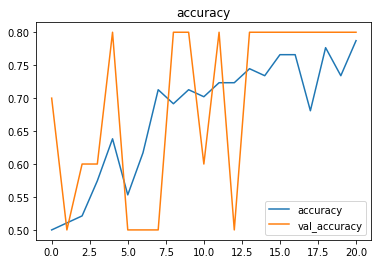

In [15]:
plot(history1.history, history2.history, "accuracy", 'val_accuracy')

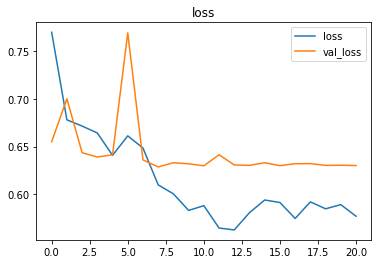

In [16]:
plot(history1.history, history2.history, "loss", 'val_loss')

# Prediction

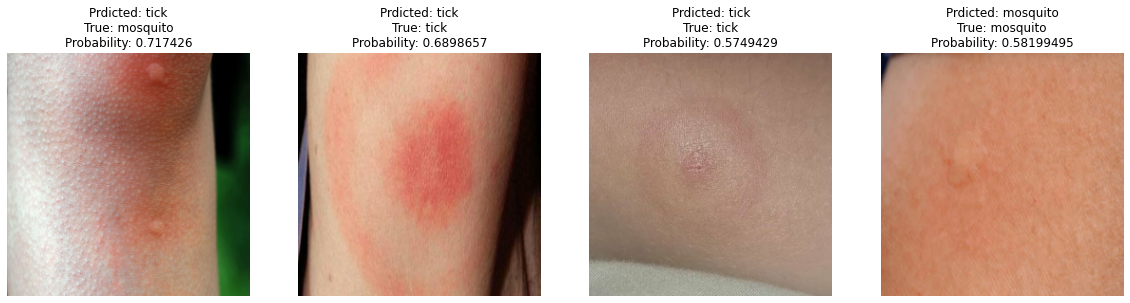

In [17]:
# prediction for all samples in the dataset

plt.figure(figsize=(20, 20))

for i in test_ds.as_numpy_iterator():
    img, label = i  
    for x in range(len(label)):  
        ax = plt.subplot(1, len(label), x + 1)
        plt.axis('off')   # remove axes
        plt.imshow(img[x])    # shape from (64, 256, 256, 3) --> (256, 256, 3)
        output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
        pred = np.argmax(output[0])    # finding max
        t = "Prdicted: " + class_names[pred]    # Picking the label from class_names base don the model output
        t = t + "\nTrue: " + class_names[label[x]]
        t = t + "\nProbability: " + str(output[0][pred])
        plt.title(t)

The low accuracy rate is due to the very few number of samples in the training set. Even after augmentation techniques, the dataset is small to obtain high results. 
This notebook is a proof of concept of how neural networks can be used to differentiate between insect bites.

# deepC

In [18]:
model.save('insect.h5')

!deepCC insect.h5

[INFO]
Reading [keras model] 'insect.h5'
[SUCCESS]
Saved 'insect.onnx'
[INFO]
Reading [onnx model] 'insect.onnx'
[INFO]
Model info:
  ir_vesion : 5
  doc       : 
[WARNING]
[ONNX]: graph-node block1_conv1's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block1_conv2's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block2_conv1's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block2_conv2's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block3_conv1's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block3_conv2's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block3_conv3's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block4_conv1's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block4_conv2's attribute auto_pad has no meaningful data.
[WARNING]
[ONNX]: graph-node block4_conv3's attribute 